<h1>Entrega 7</h1>
<p><b>Autores: Jacobo Rivas, Alejandro Esperón, Cristian Sousa, Saúl Fernández</b></p>

<p>Utilizando el dataset de reseñas de Amazon, realiza las siguientes tareas:</p>
<ol>
    <li>Tratar de encontrar los mejores valores para coherencia y perplejidad hiperparametrizando el Topic Modeling, incluyendo el número de tópicos</li>
    <li>Aplica los conocimientos aprendidos en aprendizaje supervisado para poder clasificar cuando una reseña es positiva o negativa. Puedes valerte de cualquier técnica vista en clase</li>
</ol>

Tarea 1

In [2]:
import csv
import nltk
import re
import pickle
from pathlib import Path
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import TfidfModel, LdaModel
from gensim.models import CoherenceModel
from nltk.tokenize import word_tokenize
import numpy as np

# Carga y preprocesamiento de datos
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('omw-1.4')

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

reviews = []
with open("./amazon_reviews.csv", "r", encoding="UTF-8") as csv_file:
    rows = csv.reader(csv_file, delimiter=",")
    for i, row in enumerate(rows):
        if i != 0:
            reviews.append(preprocess_text(row[6]))




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Saul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Saul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Saul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Saul\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
clean_reviews = []
word_count = {}

[clean_reviews.append(preprocess_text(review)) for review in reviews]

for clean_review in clean_reviews:
    for word in clean_review.split(" "):
        if word not in word_count:
            word_count[word] = 0
        word_count[word] += 1
        

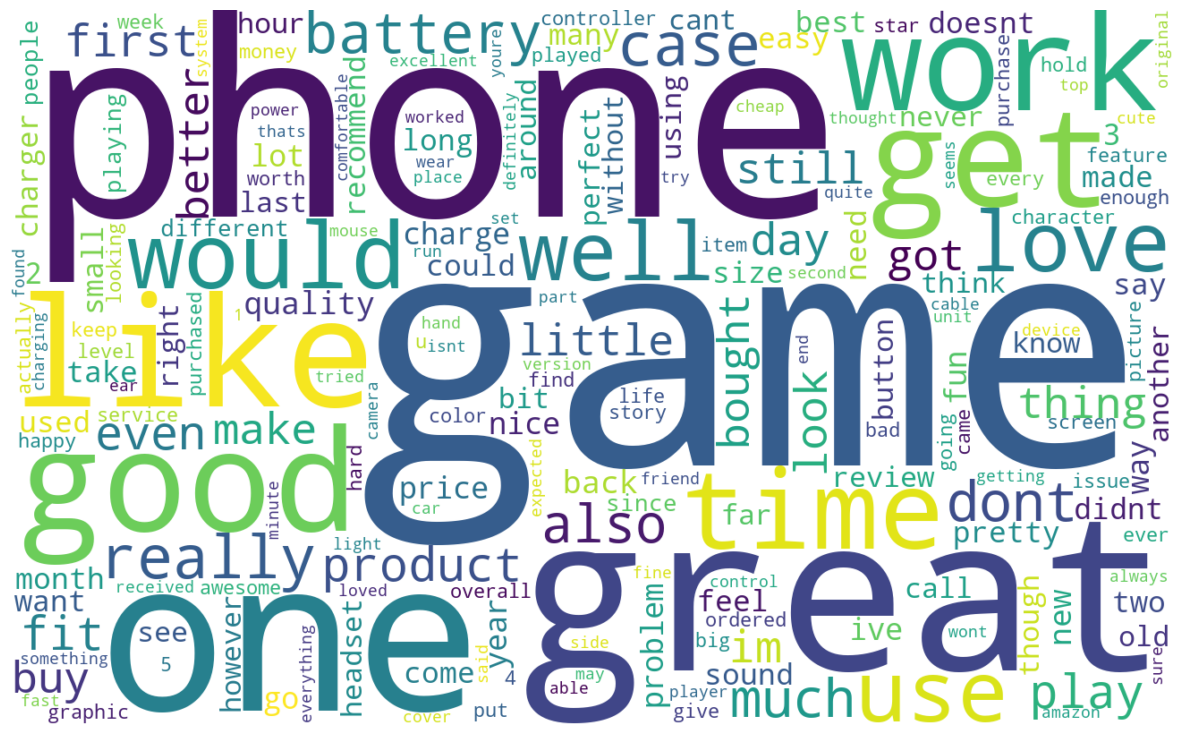

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_cloud = WordCloud(width=1300, height=800, collocations=False, background_color='white').generate_from_frequencies(word_count)
f, ax = plt.subplots(figsize=(15,12))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [5]:
from gensim.models import LdaModel
from gensim import corpora
from gensim.models import TfidfModel
from nltk.tokenize import word_tokenize
import nltk
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
import pickle
from pathlib import Path

path = Path.cwd()
nltk.download('punkt')


tokenized_documents = [word_tokenize(doc.lower()) for doc in clean_reviews]
export_model = f"{str(path)}/best_lda_model"

dictionary = corpora.Dictionary(tokenized_documents)

tfidf = TfidfModel(dictionary=dictionary)
corpus_tfidf = [tfidf[dictionary.doc2bow(doc)] for doc in tokenized_documents]

# Definir los rangos de búsqueda
num_topics_range = [3,5,7,10]
alpha_range = ['auto']
eta_range = ['auto']
iterations_range = [50, 100, 150]

best_coherence = -float('inf')
best_perplexity = float('inf')
best_params = {}

for num_topics in num_topics_range:
    for alpha in alpha_range:
        for eta in eta_range:
            for iterations in iterations_range:
                lda_model = LdaModel(
                    corpus=corpus_tfidf,
                    id2word=dictionary,
                    num_topics=num_topics,
                    alpha=alpha,
                    eta=eta,
                    iterations=iterations
                )
                
                # Calcular coherencia
                coherence_model = CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
                coherence = coherence_model.get_coherence()
                
                # Calcular perplexity
                perplexity = lda_model.log_perplexity(corpus_tfidf)
                
                # Actualizar mejores parámetros si es necesario
                if coherence > best_coherence or (coherence == best_coherence and perplexity < best_perplexity):
                    best_coherence = coherence
                    best_perplexity = perplexity
                    best_params = {
                        'num_topics': num_topics,
                        'alpha': alpha,
                        'eta': eta,
                        'iterations': iterations
                    }

# Imprimir los mejores parámetros
print("Mejores parámetros:", best_params)


# Entrenar el modelo final con los mejores parámetros
best_lda_model = LdaModel(
    corpus=corpus_tfidf,
    id2word=dictionary,
    num_topics=best_params['num_topics'],
    alpha=best_params['alpha'],
    eta=best_params['eta'],
    iterations=best_params['iterations']
)

# Guardar el mejor modelo
pickle.dump(best_lda_model, open(export_model, 'wb'))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Saul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Mejores parámetros: {'num_topics': 7, 'alpha': 'auto', 'eta': 'auto', 'iterations': 100}


In [6]:
import pickle
from gensim.models.coherencemodel import CoherenceModel

lda_model = pickle.load(open(export_model, 'rb'))

topics = lda_model.print_topics()
for topic in topics:
    print(topic)
    
perplexity = lda_model.log_perplexity(corpus_tfidf)
print(f'Perplejidad: {perplexity}')

coherence_model = CoherenceModel(model=lda_model, texts=tokenized_documents, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f'Coherencia: {coherence_score}')

(0, '0.003*"thumb" + 0.002*"ball" + 0.002*"mac" + 0.002*"hated" + 0.002*"server" + 0.002*"manner" + 0.002*"okay" + 0.002*"timely" + 0.002*"upset" + 0.002*"fiance"')
(1, '0.026*"love" + 0.015*"awesome" + 0.012*"son" + 0.008*"thank" + 0.005*"3d" + 0.005*"nephew" + 0.004*"birthday" + 0.004*"pokemon" + 0.004*"worked" + 0.004*"brother"')
(2, '0.004*"thanks" + 0.003*"beat" + 0.003*"red" + 0.002*"mission" + 0.002*"great" + 0.002*"shoe" + 0.002*"older" + 0.002*"hat" + 0.002*"console" + 0.002*"quality"')
(3, '0.011*"excellent" + 0.005*"fast" + 0.005*"controller" + 0.004*"shipping" + 0.004*"product" + 0.004*"content" + 0.003*"alot" + 0.003*"god" + 0.003*"work" + 0.003*"great"')
(4, '0.017*"grandson" + 0.011*"ok" + 0.008*"described" + 0.006*"remote" + 0.003*"awsome" + 0.002*"boot" + 0.002*"product" + 0.002*"lover" + 0.001*"listened" + 0.001*"dose"')
(5, '0.019*"game" + 0.010*"great" + 0.008*"good" + 0.006*"work" + 0.005*"fun" + 0.005*"play" + 0.005*"like" + 0.005*"love" + 0.005*"one" + 0.004*"tim

In [7]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

lda_display = gensimvis.prepare(lda_model, corpus_tfidf, dictionary, sort_topics = False)

pyLDAvis.save_html(lda_display, 'visualization.html')

Tarea 2

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def matriz_confusion(y_test, y_pred):
    predictions = y_pred
    cnf_matrix=confusion_matrix(y_test,predictions)
    lfg, ax = plt.subplots(1)
    ax =sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens,annot=True)
    plt.title('Confusion matrix')
    plt.ylabel('True category')
    plt.xlabel('Predicted category')
    plt.show()

    print(classification_report(y_test,predictions))
    print("Accuracy:", accuracy_score(y_test, y_pred))

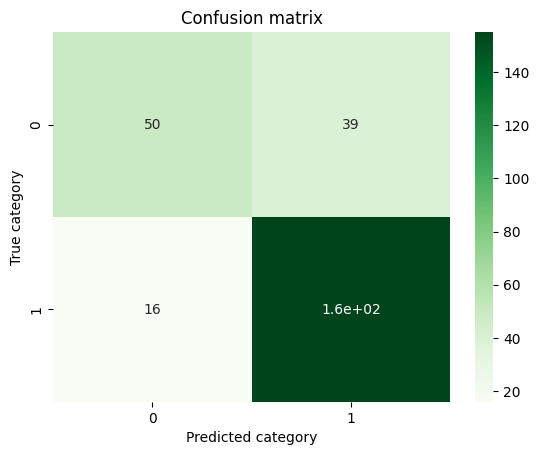

              precision    recall  f1-score   support

           0       0.76      0.56      0.65        89
           1       0.80      0.91      0.85       171

    accuracy                           0.79       260
   macro avg       0.78      0.73      0.75       260
weighted avg       0.78      0.79      0.78       260

Accuracy: 0.7884615384615384


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC


# Cargar y muestrear datos
df = pd.read_csv('./amazon_reviews.csv')
df_sample = df.sample(frac=0.1, random_state=42)  # Reduce el tamaño del conjunto de datos

# Preprocesamiento simple
df_sample['processed_text'] = df_sample['reviewText'].str.lower()

# Etiquetas
df_sample['label'] = df_sample['overall'].apply(lambda x: 1 if x > 3 else 0)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(df_sample['processed_text'], df_sample['label'], test_size=0.2, random_state=42)

# Vectorización
vectorizer = TfidfVectorizer(max_features=1000)  # Reducir el número de características
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Modelo
model = LinearSVC(dual=True)
model.fit(X_train_vec, y_train)

# Predicción y evaluación
y_pred = model.predict(X_test_vec)

matriz_confusion(y_test, y_pred)
